<a href="https://colab.research.google.com/github/duraichellam001-tech/EV-PhysicsCalib-Model/blob/main/notebooks/01_dataset_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
drive.mount('/content/drive')

import os, numpy as np, pandas as pd
from scipy.ndimage import uniform_filter1d
from tqdm import trange
import random

Mounted at /content/drive



Processing udds | mean speed = 8.73 m/s


Augmenting udds:   0%|          | 0/10 [00:00<?, ?it/s]

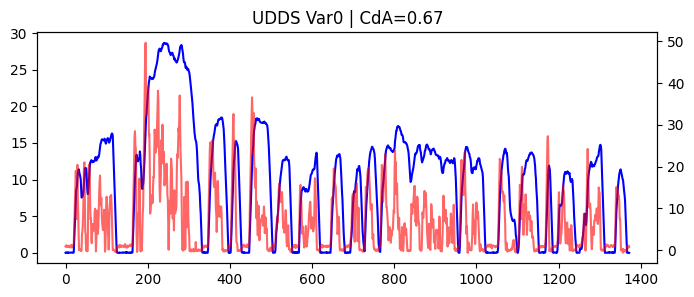

Augmenting udds:  10%|█         | 1/10 [00:00<00:02,  4.44it/s]

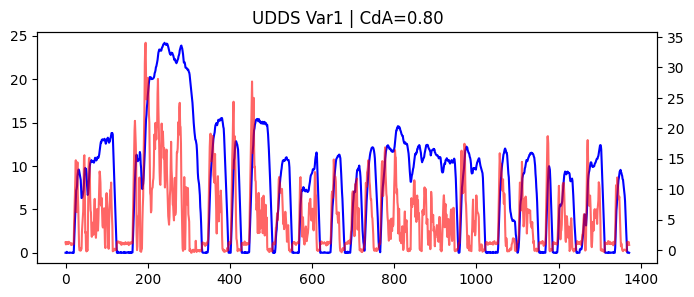

Augmenting udds: 100%|██████████| 10/10 [00:00<00:00, 21.82it/s]



Processing epa_hwy | mean speed = 21.55 m/s


Augmenting epa_hwy:   0%|          | 0/10 [00:00<?, ?it/s]

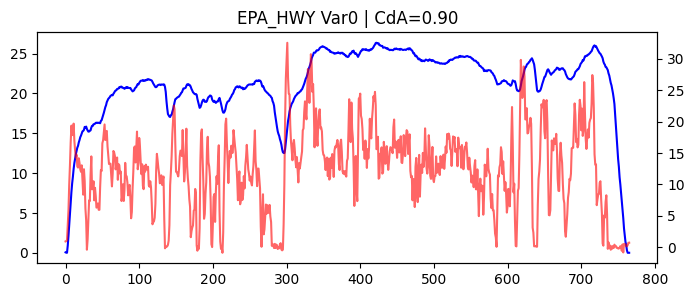

Augmenting epa_hwy:  10%|█         | 1/10 [00:00<00:03,  2.53it/s]

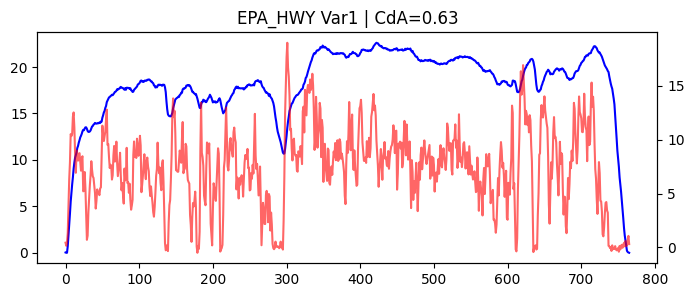

Augmenting epa_hwy: 100%|██████████| 10/10 [00:00<00:00, 13.55it/s]



Processing us06 | mean speed = 21.59 m/s


Augmenting us06:   0%|          | 0/10 [00:00<?, ?it/s]

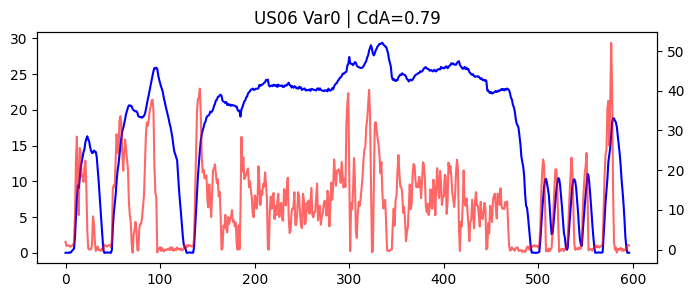

Augmenting us06:  10%|█         | 1/10 [00:00<00:02,  3.24it/s]

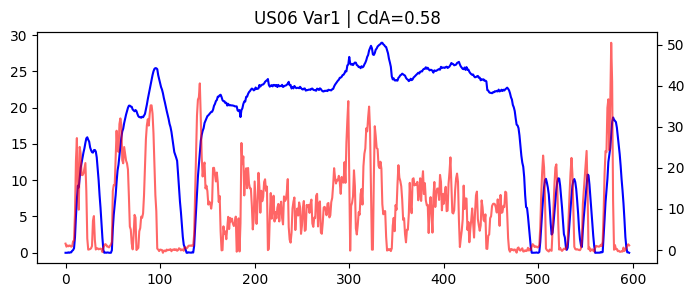

Augmenting us06: 100%|██████████| 10/10 [00:00<00:00, 16.23it/s]

✅ Generated 30 real_aug cycles.


In [45]:
# ===============================================================
# 2️⃣  Real Cycle Augmentation (UDDS, HWY, US06)
# ===============================================================
def load_base_cycle(fname):
    df = pd.read_csv(fname)
    df.columns = ['time', 'speed_mph'][:len(df.columns)]
    df['v_mps'] = df['speed_mph'] * 0.44704
    df['a_mps2'] = np.gradient(df['v_mps'], np.mean(np.diff(df['time'])))
    return df[['time', 'v_mps', 'a_mps2']]

def compute_P_batt(v, a, CdA, Crr, eta, mass, Paux):
    F_rr = mass * g * Crr
    F_aero = 0.5 * rho * CdA * v**2
    F_acc = mass * a
    F_total = F_rr + F_aero + F_acc
    P_wheel = F_total * v
    P_batt = (P_wheel / (eta + 1e-9)) + Paux
    return np.clip(P_batt, 0, None)

# --- Generate and visualize ---
all_meta = []
cycle_counter = 0
variants_per_cycle = 10  # increase later

for base_name, fname in base_cycle_files.items():
    df_base = load_base_cycle(fname)
    print(f"\nProcessing {base_name} | mean speed = {df_base['v_mps'].mean():.2f} m/s")

    for var_idx in trange(variants_per_cycle, desc=f"Augmenting {base_name}"):
        scale = np.random.uniform(0.8, 1.2)
        noise = np.random.normal(0, 0.05, len(df_base))
        v = np.clip(df_base['v_mps'].values * scale + noise, 0, None)
        t = df_base['time'].values
        a = np.gradient(v, np.mean(np.diff(t)))

        CdA = np.random.uniform(*param_ranges['CdA'])
        Crr = np.random.uniform(*param_ranges['Crr'])
        eta = np.random.uniform(*param_ranges['eta'])
        Paux = np.random.uniform(*param_ranges['P_aux'])
        mass = np.random.uniform(*param_ranges['mass'])

        P_meas = compute_P_batt(v, a, CdA, Crr, eta, mass, Paux)
        P_meas += np.random.normal(0, 0.03*np.mean(P_meas), len(P_meas))

        df_out = pd.DataFrame({
            'cycle_id': cycle_counter, 'base_cycle': base_name,
            'variant_idx': var_idx, 'time_s': t,
            'v_mps': v, 'a_mps2': a, 'P_meas_W': P_meas,
            'CdA': CdA, 'Crr': Crr, 'eta': eta,
            'P_aux_W': Paux, 'mass_kg': mass
        })

        if var_idx < 2:  # show first two for verification
            plt.figure(figsize=(8,3))
            plt.plot(t, v, 'b')
            plt.twinx(); plt.plot(t, P_meas/1000, 'r', alpha=0.6)
            plt.title(f"{base_name.upper()} Var{var_idx} | CdA={CdA:.2f}")
            plt.show()

        # Uncomment when ready to save
        # df_out.to_csv(os.path.join(OUT_DIR, f"{base_name}_{var_idx:03d}.csv"), index=False)
        all_meta.append({'cycle_id': cycle_counter, 'type': 'real_aug', 'source': base_name})
        cycle_counter += 1

print(f"✅ Generated {cycle_counter} real_aug cycles.")


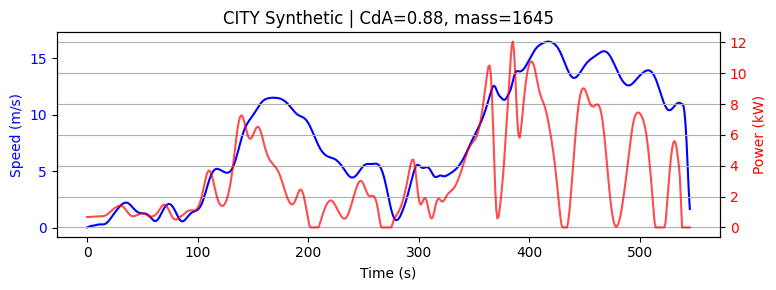

City       | mean_v= 7.83 m/s | max_v=16.46 | max_a=0.39 | max_P= 12.1 kW


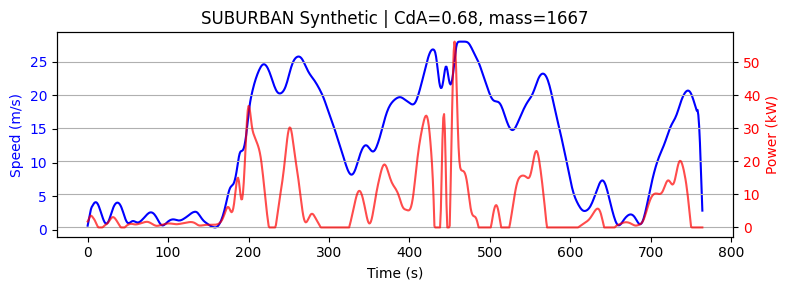

Suburban   | mean_v=12.76 m/s | max_v=28.00 | max_a=1.09 | max_P= 56.3 kW


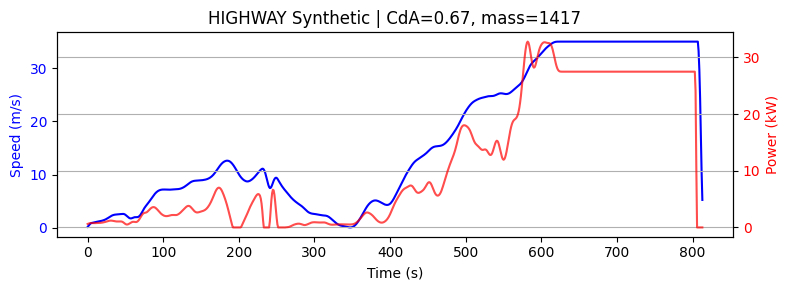

Highway    | mean_v=16.66 m/s | max_v=35.00 | max_a=0.39 | max_P= 32.8 kW


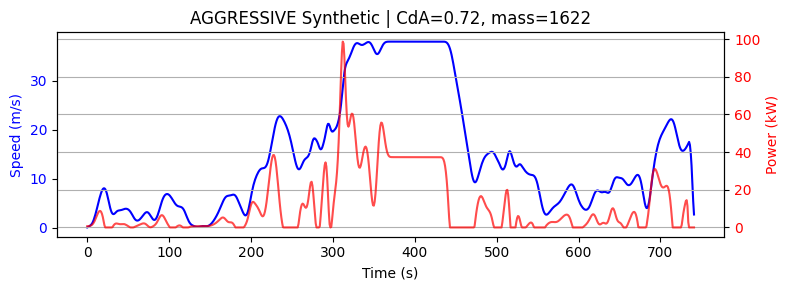

Aggressive | mean_v=14.82 m/s | max_v=38.00 | max_a=1.69 | max_P= 98.7 kW


In [72]:
# ===============================================================
# 3️⃣  Synthetic Cycle Generation (Final Stable Version — Smooth End)
# ===============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d, gaussian_filter1d
from tqdm import trange

# ---------------- GLOBAL PARAMETERS ----------------
DT = 1.0                 # time resolution (1 Hz)
max_acc = 3.0            # m/s²
max_dv = max_acc * DT
global_smooth = 8        # moving average window
gauss_sigma = 1.15        # Gaussian smoothing
ramp_seconds = 3         # ramp in/out near stops

# physical constants
g = 9.81
rho = 1.225

param_ranges = {
    'CdA': (0.55, 0.9),
    'Crr': (0.009, 0.015),
    'eta': (0.85, 0.95),
    'P_aux': (300, 1200),   # W
    'mass': (1300, 1800)    # kg
}


# ---------------- SAFE BATTERY POWER COMPUTATION ----------------
from scipy.ndimage import uniform_filter1d

def compute_P_batt_fixed(t, v, CdA, Crr, eta, mass, Paux,
                         smooth_window=5, max_acc=3.0, max_power=120e3):
    """Smooth velocity, limit accel, and clip power to safe range."""
    v_s = uniform_filter1d(np.asarray(v), size=smooth_window, mode='nearest')
    dt = np.mean(np.diff(t)) if len(t) > 1 else 1.0
    a = np.gradient(v_s, dt)
    a = np.clip(a, -max_acc, max_acc)

    F_rr = mass * g * Crr
    F_aero = 0.5 * rho * CdA * v_s**2
    F_acc = mass * a
    F_total = F_rr + F_aero + F_acc

    P_wheel = F_total * v_s
    P_batt = P_wheel / (eta + 1e-9) + Paux

    # smooth and clip
    P_batt = uniform_filter1d(P_batt, size=3, mode='nearest')
    P_batt = np.clip(P_batt, 0, max_power)
    return P_batt, a


# ---------------- VELOCITY HELPERS ----------------
def ramp_sequence(length, ramp_len):
    """Create a ramp-down, hold, ramp-up pattern."""
    out = np.ones(length)
    if ramp_len <= 0:
        return out
    for i in range(ramp_len):
        out[i] = (i+1)/(ramp_len+1)
        out[-1-i] = (i+1)/(ramp_len+1)
    return out

def clip_dv_to_max(v, dv_max):
    """Ensure |v[i+1]-v[i]| ≤ dv_max."""
    v = v.copy()
    for i in range(1, len(v)):
        dv = v[i] - v[i-1]
        if dv > dv_max:
            v[i] = v[i-1] + dv_max
        elif dv < -dv_max:
            v[i] = v[i-1] - dv_max
    return v


# ---------------- PATCH END RAMP ----------------
def patch_end_ramp(v, ramp_seconds=3, DT=1.0, max_v=None):
    """
    Ensure velocity starts/ends at zero with smooth linear ramps.
    """
    v = np.asarray(v, dtype=float).copy()
    n = len(v)
    ramp_n = int(max(4, round(ramp_seconds / DT)))

    # --- start ramp ---
    if n > ramp_n:
        v[:ramp_n] = np.linspace(0.0, float(v[ramp_n]), ramp_n)

    # --- end ramp ---
    # find last stable pre-ramp velocity (avoid low tail)
    if n > 3 * ramp_n:
        pre_seg = v[-3*ramp_n:-ramp_n]
        pre_level = float(np.percentile(pre_seg, 90))  # high percentile avoids early decay
    else:
        pre_level = float(np.max(v))

    # if pre_level > 2 m/s, extend ramp
    ramp_n_eff = ramp_n + 1 if pre_level > 2 else ramp_n
    v[-ramp_n_eff:] = np.linspace(pre_level, 0.0, ramp_n_eff)

    # small smoothing
    v = uniform_filter1d(v, size=5, mode='nearest')

    if max_v is not None:
        v = np.clip(v, 0, max_v)
    return v


# ---------------- MAIN GENERATOR ----------------
def make_synthetic_cycle_safe(style='city', T=None, seed=None):
    """Generate realistic synthetic drive cycle."""
    if seed is not None:
        np.random.seed(seed)

    # ---- Style presets ----
    if style == 'city':
        T = T or np.random.randint(500, 900)
        mean_v, max_v, base_smooth = 8, 20, 12
    elif style == 'suburban':
        T = T or np.random.randint(600, 950)
        mean_v, max_v, base_smooth = 13, 28, 18
    elif style == 'highway':
        T = T or np.random.randint(800, 1200)
        mean_v, max_v, base_smooth = 20, 35, 30
    else:  # aggressive
        T = T or np.random.randint(500, 900)
        mean_v, max_v, base_smooth = 16, 38, 8

    t = np.arange(0, T, DT)
    n = len(t)

    # ---- 1) Base random velocity ----
    base = np.cumsum(np.random.randn(n))
    v = uniform_filter1d(base, size=base_smooth, mode='nearest')
    v = np.abs(v)
    v = v / (np.mean(v) + 1e-9) * mean_v
    v = np.clip(v, 0, max_v)

    # ---- 2) Insert smooth stops ----
    num_stops = np.random.randint(2, 6)
    for _ in range(num_stops):
        pos = np.random.randint(40, n - 40)
        stop_len = np.random.randint(4, 20)
        start = max(0, pos - stop_len // 2)
        end = min(n, start + stop_len)
        v[start:end] *= ramp_sequence(end - start, int(ramp_seconds))

    # ---- 3) Smooth globally ----
    v = uniform_filter1d(v, size=global_smooth, mode='nearest')
    v = gaussian_filter1d(v, sigma=gauss_sigma)

    # ---- 4) Clip per-step dv ----
    v = clip_dv_to_max(v, max_dv)

    # ---- 5) Force start/end to zero smoothly ----
    v = patch_end_ramp(v, ramp_seconds=ramp_seconds, DT=DT, max_v=max_v)

    # ---- 6) Compute accel ----
    a = np.gradient(v, DT, edge_order=2)
    a[-3:] = np.linspace(a[-4], 0, 3)  # force accel to 0 near end
    a = np.clip(a, -max_acc, max_acc)
    return t, v, a


# ---------------- VISUALIZE EXAMPLES ----------------
for style in ['city', 'suburban', 'highway', 'aggressive']:
    t, v, a = make_synthetic_cycle_safe(style)

    # Random physical params within realistic ranges
    CdA = np.random.uniform(*param_ranges['CdA'])
    Crr = np.random.uniform(*param_ranges['Crr'])
    eta = np.random.uniform(*param_ranges['eta'])
    Paux = np.random.uniform(*param_ranges['P_aux'])
    mass = np.random.uniform(*param_ranges['mass'])

    # Compute power
    P_batt, _ = compute_P_batt_fixed(t, v, CdA, Crr, eta, mass, Paux)

    # --- Plot ---
    fig, ax1 = plt.subplots(figsize=(8,3))
    ax1.plot(t, v, 'b', label='Speed (m/s)')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Speed (m/s)', color='b')
    ax1.tick_params(axis='y', labelcolor='b')

    ax2 = ax1.twinx()
    ax2.plot(t, P_batt/1000, 'r', alpha=0.7, label='Power (kW)')
    ax2.set_ylabel('Power (kW)', color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    plt.title(f"{style.upper()} Synthetic | CdA={CdA:.2f}, mass={mass:.0f}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"{style.capitalize():<10} | mean_v={v.mean():5.2f} m/s | "
          f"max_v={v.max():5.2f} | max_a={np.max(a):4.2f} | max_P={np.max(P_batt)/1000:5.1f} kW")


In [73]:
import os, numpy as np, pandas as pd
from tqdm import trange
from scipy.ndimage import uniform_filter1d

# ----------------------------------------------------------
# Paths
# ----------------------------------------------------------
from google.colab import drive
drive.mount('/content/drive')

base_dir = "/content/drive/My Drive/Colab Notebooks/ev-range-model/data"
out_dir = "/content/drive/My Drive/Colab Notebooks/ev-cal-estim-model/data"
os.makedirs(out_dir, exist_ok=True)

# ----------------------------------------------------------
# Base cycles (time, speed_mph)
# ----------------------------------------------------------
base_cycle_files = {
    'udds': os.path.join(base_dir, 'UDDS.csv'),
    'epa_hwy': os.path.join(base_dir, 'EPA_HWY.csv'),
    'us06': os.path.join(base_dir, 'EPA_US06.csv')
}

# ----------------------------------------------------------
# Config
# ----------------------------------------------------------
variants_per_base = 70     # number of augmented versions per real cycle
synthetic_plan = {
    'city': 100,
    'suburban': 100,
    'highway': 100,
    'aggressive': 50
}

# ----------------------------------------------------------
# Function to load and augment real base cycles
# ----------------------------------------------------------
def load_base_cycle(fname):
    df = pd.read_csv(fname)
    df.columns = ['time', 'speed_mph'][:len(df.columns)]
    df['v_mps'] = df['speed_mph'] * 0.44704
    df['a_mps2'] = np.gradient(df['v_mps'], np.mean(np.diff(df['time'])))
    return df[['time', 'v_mps', 'a_mps2']]

def augment_cycle(df, factor_v=1.0, noise_level=0.05):
    v = df['v_mps'].values * factor_v
    v += np.random.normal(0, noise_level, len(v))
    v = np.clip(v, 0, None)
    t = df['time'].values
    a = np.gradient(v, np.mean(np.diff(t)))
    return pd.DataFrame({'time_s': t, 'v_mps': v, 'a_mps2': a})

# ----------------------------------------------------------
# Metadata collection
# ----------------------------------------------------------
meta_records = []
cycle_counter = 0

# ----------------------------------------------------------
# 1️⃣ Augmented Real Cycles
# ----------------------------------------------------------
for base_name, base_path in base_cycle_files.items():
    df_base = load_base_cycle(base_path)
    for i in trange(variants_per_base, desc=f"Augmenting {base_name}"):
        f_v = np.random.uniform(0.8, 1.2)
        df_aug = augment_cycle(df_base, factor_v=f_v, noise_level=0.1)

        CdA  = np.random.uniform(*param_ranges['CdA'])
        Crr  = np.random.uniform(*param_ranges['Crr'])
        eta  = np.random.uniform(*param_ranges['eta'])
        Paux = np.random.uniform(*param_ranges['P_aux'])
        mass = np.random.uniform(*param_ranges['mass'])

        P_batt, _ = compute_P_batt_fixed(df_aug['time_s'], df_aug['v_mps'], CdA, Crr, eta, mass, Paux)
        df_aug['P_meas_W'] = P_batt

        df_aug['CdA'] = CdA
        df_aug['Crr'] = Crr
        df_aug['eta'] = eta
        df_aug['P_aux_W'] = Paux
        df_aug['mass_kg'] = mass
        df_aug['style'] = base_name
        df_aug['source'] = 'real_aug'

        fname = f"{base_name}_aug_{cycle_counter:04d}.csv"
        df_aug.to_csv(os.path.join(out_dir, fname), index=False)

        meta_records.append({
            'cycle_id': cycle_counter,
            'file': fname,
            'type': 'real_aug',
            'base_cycle': base_name,
            'mean_v': np.mean(df_aug['v_mps']),
            'max_v': np.max(df_aug['v_mps']),
            'mean_P_kW': np.mean(P_batt) / 1000,
            'max_P_kW': np.max(P_batt) / 1000
        })
        cycle_counter += 1

# ----------------------------------------------------------
# 2️⃣ Synthetic Cycles
# ----------------------------------------------------------
for style, n_cycles in synthetic_plan.items():
    print(f"Generating {n_cycles} {style} synthetic cycles...")
    for i in trange(n_cycles):
        t, v, a = make_synthetic_cycle_safe(style=style)

        CdA  = np.random.uniform(*param_ranges['CdA'])
        Crr  = np.random.uniform(*param_ranges['Crr'])
        eta  = np.random.uniform(*param_ranges['eta'])
        Paux = np.random.uniform(*param_ranges['P_aux'])
        mass = np.random.uniform(*param_ranges['mass'])

        P_batt, _ = compute_P_batt_fixed(t, v, CdA, Crr, eta, mass, Paux)

        df = pd.DataFrame({
            'time_s': t,
            'v_mps': v,
            'a_mps2': a,
            'P_meas_W': P_batt,
            'CdA': CdA,
            'Crr': Crr,
            'eta': eta,
            'P_aux_W': Paux,
            'mass_kg': mass,
            'style': style,
            'source': 'synthetic'
        })

        fname = f"{style}_{cycle_counter:04d}.csv"
        df.to_csv(os.path.join(out_dir, fname), index=False)

        meta_records.append({
            'cycle_id': cycle_counter,
            'file': fname,
            'type': 'synthetic',
            'base_cycle': style,
            'mean_v': np.mean(v),
            'max_v': np.max(v),
            'mean_P_kW': np.mean(P_batt) / 1000,
            'max_P_kW': np.max(P_batt) / 1000
        })
        cycle_counter += 1

# ----------------------------------------------------------
# 3️⃣ Save metadata
# ----------------------------------------------------------
meta_df = pd.DataFrame(meta_records)
meta_df.to_csv(os.path.join(out_dir, "metadata.csv"), index=False)

print(f"\n✅ Generated {cycle_counter} total cycles (real_aug + synthetic)")
print(meta_df.groupby(['type', 'base_cycle'])[['mean_v', 'mean_P_kW']].mean().round(2))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Augmenting us06: 100%|██████████| 70/70 [00:02<00:00, 23.39it/s]


Generating 100 city synthetic cycles...


100%|██████████| 100/100 [00:03<00:00, 32.92it/s]


Generating 100 suburban synthetic cycles...


100%|██████████| 100/100 [00:03<00:00, 26.51it/s]


Generating 100 highway synthetic cycles...


100%|██████████| 100/100 [00:04<00:00, 24.92it/s]


Generating 50 aggressive synthetic cycles...


100%|██████████| 50/50 [00:02<00:00, 24.50it/s]



✅ Generated 560 total cycles (real_aug + synthetic)
                      mean_v  mean_P_kW
type      base_cycle                   
real_aug  epa_hwy      21.61      11.65
          udds          8.74       5.01
          us06         21.75      17.17
synthetic aggressive   15.54      10.04
          city          7.75       3.31
          highway      18.81      12.66
          suburban     12.46       6.38
